In [1]:
# Allow importing from the code directory.
import sys
sys.path.append('../code/')

In [2]:
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt

from matplotlib.colors import to_rgba

from sklearn.preprocessing import LabelEncoder, TargetEncoder
from sklearn.metrics import classification_report, confusion_matrix
from etch import load_census, create_census_pipeline, SelectFromCollection

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


In [3]:
from IPython.display import display, clear_output
import ipywidgets as widgets

%matplotlib widget

In [4]:
census = load_census()

In [5]:
# model = RandomForestClassifier(random_state=42)
# This doesn't converge for some reason.
model = LogisticRegression(max_iter=500, random_state=42)
transformer = None
# transformer = TargetEncoder()
pipeline = create_census_pipeline(model, transformer=transformer)

In [6]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(census.y_train)
y_test_encoded = encoder.transform(census.y_test)


In [7]:
pipeline.fit(census.X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['age', 'wage per hour',
                                                   'capital gains',
                                                   'capital losses',
                                                   'dividends from stocks',
                                                   'num persons worked for '
                                                   'employer',
                                                   'weeks worked in year']),
                                                 ('one',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['class of worker',
                                                   'detailed industry recode',
                                                   'detailed occupation reco...
                                                                                               'Associates '
                                                                                               'degree-occup '
                                                                                               '/vocational',
                                                                                               ' '
                                                                                               'Associates '
                                                                                               'degree-academic '
                                                                                               'program',
                                                                                               ' '
                                                                                               'Bachelors '
                                                                                               'degree(BA '
                                                                                               'AB '
                                                                                               'BS)',
                                                                                               ' '
                                                                                               'Masters '
                                                                                               'degree(MA '
                                                                                               'MS '
                                                                                               'MEng '
                                                                                               'MEd '
                                                                                               'MSW '
                                                                                               'MBA)',
                                                                                               ' '
                                                                                               'Doctorate '
                                                                                               'degree(PhD '
                                                                                               'EdD)',
                                                                                               ' '
                                                                                               'Prof '
                                                                                               'school '
                                                                                               'd

In [8]:
y_test_probabilities = pipeline.predict_proba(census.X_test)
y_test_predictions = (y_test_probabilities[:, 1] >= 0.5).astype(int)

print(classification_report(y_test_encoded, y_test_predictions))
print(confusion_matrix(y_test_encoded, y_test_predictions))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     93576
           1       0.74      0.39      0.51      6186

    accuracy                           0.95     99762
   macro avg       0.85      0.69      0.74     99762
weighted avg       0.95      0.95      0.95     99762

[[92711   865]
 [ 3774  2412]]


In [9]:
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(pd.DataFrame(pipeline.named_steps["preprocessor"].transform(census.X_test), columns=pipeline.named_steps["preprocessor"].get_feature_names_out()))


/opt/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


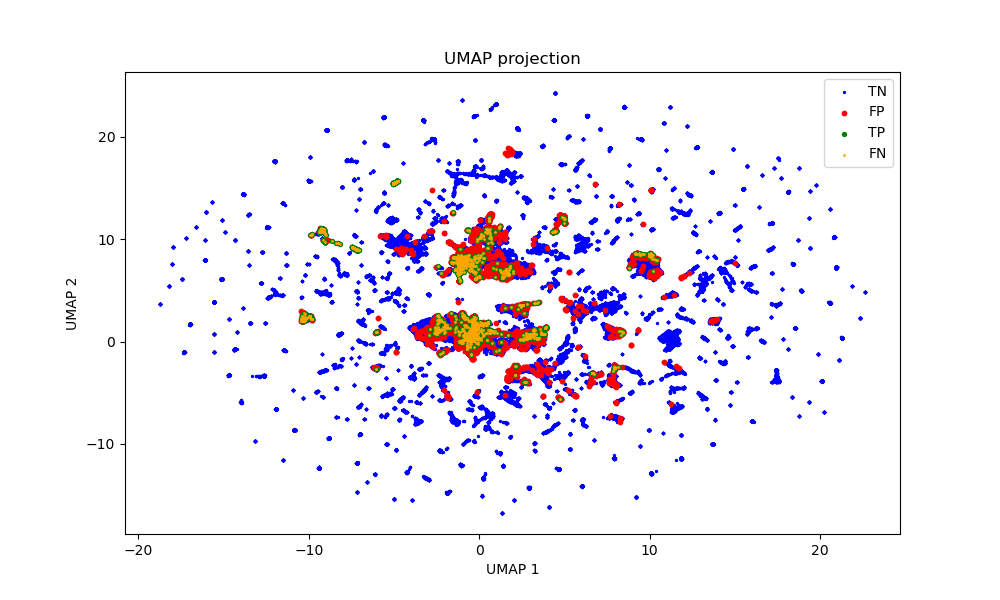

In [10]:
plt.figure(figsize=(10, 6))

indices = (y_test_encoded == 0) & (y_test_predictions == 0)
plt.scatter(X_umap[indices, 0], X_umap[indices, 1], color='blue', label='TN', s=2)

indices = (y_test_encoded == 1) & (y_test_predictions == 0)
plt.scatter(X_umap[indices, 0], X_umap[indices, 1], color='red', label='FP', s=10)

indices = (y_test_encoded == 1) & (y_test_predictions == 1)
plt.scatter(X_umap[indices, 0], X_umap[indices, 1], color='green', label='TP', s=8)

indicies = (y_test_encoded == 0) & (y_test_predictions == 1)
plt.scatter(X_umap[indices, 0], X_umap[indices, 1], color='orange', label='FN', s=1)

plt.title('UMAP projection')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.savefig('../results/umap.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


In [11]:
# LOL why did I even make this?

# try:
#     plt.close(fig)
# except:
#     pass

# df = census.X_test.copy()
# df.loc[:, ["UMAP1", "UMAP2"]] = X_umap
# df.loc[(y_test_encoded == 0) & (y_test_predictions == 0), "Label"] = "TN"
# df.loc[(y_test_encoded == 1) & (y_test_predictions == 0), "Label"] = "FP"
# df.loc[(y_test_encoded == 1) & (y_test_predictions == 1), "Label"] = "TP"
# df.loc[(y_test_encoded == 0) & (y_test_predictions == 1), "Label"] = "FN"

# df_fp = df[df['Label'] == 'FP']

# default_max_columns = pd.get_option('display.max_columns')
# pd.set_option('display.max_columns', None)

# output = widgets.Output()

# def frame(ind):
#     with output:
#         clear_output(wait=True)
#         display(df_fn.iloc[ind])

# fig, ax = plt.subplots(figsize=(10, 6))

# default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# rgba_colors = [to_rgba(color) for color in default_colors]

# collection = ax.scatter(df_fp['UMAP1'], df_fp['UMAP2'])
# ax.set_xlabel('UMAP1')
# ax.set_ylabel('UMAP2')

# selector = SelectFromCollection(ax, collection, onscreen=frame)

# display(output)
